# Introduction to Bayesian Data Analysis

<i>Alfred J. Reich</i>

### Overview

This notebook uses a very simple simulation (inefficient, but lucid) to illustrate how the <b>Bayesian posterior</b> distribution for a <b>Binomial</b> <i>success rate</i> (i.e., a <i>parameter</i>) can be computed when a <b>Uniform prior distribution</b> on the parameter is assumed.

Following that demonstration, the 90+ continuous distributions of <i>SciPy.stats</i> are searched to find the distribution that best fits the posterior distribution found, above.  (<u>Spoiler Alert</u>: The best fitting distribution closely matches the well-known theoretical answer to this problem, the <b>Beta distribution</b>.)

Finally, we will do the whole thing all over again, succinctly and quickly (i.e., efficient, but less lucid), using a <b>Markov chain Monte Carlo (MCMC)</b> simulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [2]:
import numpy as np
import scipy.stats as ss
from scipy.stats import binom, uniform
from functools import reduce

import fitdist as fd

## Conditional Probability

Let $A$ and $B$ be events from a set of possible events $\mathcal B$.  Then the expression, $P_{\mathcal B}(A \mid B)$, represents the <i>conditional probability</i> of the event $A$ <u>given</u> that we know that the event $B$ has already occurred.  

Example:
* Choose a card at random from a deck of 52 playing cards
* What is the probability that the card is a <i>Heart</i>? <b>P(Heart) = 1/4</b>
* What is the probability that the card is a <i>Heart</i>, given that we know the card is <i>red</i>?  <b>P(Heart | Red) = 1/2</b>

A conditional probability can be calculated as follows:

$P_{\mathcal B}(A \mid B) = \dfrac {P_{\mathcal B}(A \cap B)} {P_{\mathcal B}(B)}$

So, P( Heart | Red ) = P( Heart & Red ) / P( Red ) = (1/4) / (1/2) = 1/2

##  Bayes Theorem

By using the definition of conditional probability, above, and the fact that set intersection is symmetric, i.e., ${P_{\mathcal B}(A \cap B)} = {P_{\mathcal B}(B \cap A)}$, we can also write an expression for the probability of $B$ given $A$:

$P_{\mathcal B}(B \mid A) = \dfrac {P_{\mathcal B}(A \cap B)} {P_{\mathcal B}(A)}$

Combining the last two expessions for conditional probabilities, we obtain <i>Bayes Theorem</i>:

$P_{\mathcal B}(B \mid A) = \dfrac {P_{\mathcal B}(A \mid B) P_{\mathcal B}(B)} {P_{\mathcal B}(A)}$

Note that Bayes Theorem is a statement about probabilities.  Bayes Theorem is at the heart of <i>Bayesian Statistical Analysis</i>, but at this point, we have not yet defined <i>statistics</i>.  So, using Bayes Theorem, as defined above, does not mean that we are "doing" Bayesian Statistical Analysis.

To actually *do* Bayesian Statistical Analysis, or any kind of statistics, for that matter, we need some more definitions and results.

First, we provide a short refresher on the binomial distribution.

## Binomial Distribution

A discrete distribution representing the probability of <b>k</b> successes in <b>n</b> independent trials, where the probability of success on each individual trial is <b>p</b>.

### Example 1

<u>Question</u>:

* Toss a fair coin 4 times.
* What is the probability that we will see exactly 2 heads (H) in the 4 tosses?

<u>Answer</u>:

* There are $2^4 = 16$ ways, in sequential order, that the 4 tosses can occur (HHHH, HHHT, HHTH, ..., TTTT).
* Each is equally likely, so each has probability 1/16 of occurring.
* Only 6 of the ways contain exactly 2 heads: HHTT, HTHT, HTTH, THHT, THTH, TTHH.
* So the probability of getting 2 heads in 4 coin tosses is $6*(1/16) = 0.375$.

Or, we can just use SciPy's binomial <b>probability mass function (PMF)</b> as follows:

In [3]:
binom.pmf(2, 4, 1/2)  # 2 successes in 4 trials with p = 1/2

0.3750000000000001

### General Form of the Binomial PMF

In general, the form of the binomial PMF is the following.

$f(k;p,n) =  \binom{n}{k} p^k(1-p)^{n-k}$, for $k \in \{0,1,2,...,n\}$ and where $\binom{n}{k} = \frac{n!}{k!(n-k)!}$

The $\binom{n}{k}$ in the formula above provides the number of ways <b>k</b> successes can occur in <b>n</b> trials. So, for the example here: $\binom{4}{2} = \frac{4!}{2!(4-2)!} = 6$.

Just FYI, the theoretical <b>mean</b> and <b>variance</b> of a <b>binom(n,k)</b> are as follows:

$E(X) = np$
<p>$Var(X) = np(1−p)$</p>

### Example 2

Consider the probability of <b>k</b> successes in 20 independent trials, where the probability of success on each individual trial is <b>30%</b>.

That is,

* n = 20
* p = 0.3
* Possible values of k are 0, 1, 2, ... , 20

In [4]:
n = 20
p = 0.3

In [5]:
print(f"So, theoretically, we should see np = {n} x {p} = {n*p} successes.")

So, theoretically, we should see np = 20 x 0.3 = 6.0 successes.


In [6]:
print(f"Or, using SciPy.stat's binomial random variable: {binom(n,p).mean()} successes")

Or, using SciPy.stat's binomial random variable: 6.0 successes


Of course, other outcomes are possible.  We can get anywhere from 0 to 20 successes in 20 trials.  The probabilities for each of the 21 possible outcomes (values of k) are shown in the graph below.  The <b>Binomial(20, 0.3)</b> PMF is graphed below.

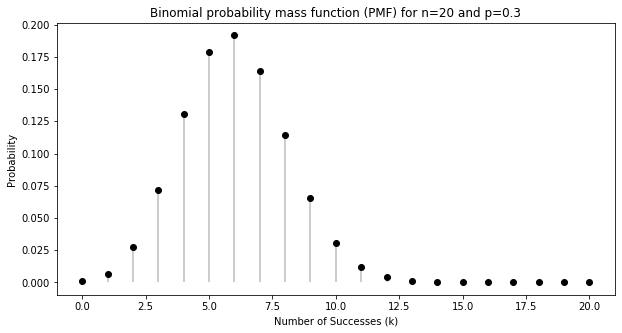

In [7]:
x = np.arange(0, n + 1)

figsize(10,5)
plt.plot(x, binom.pmf(x,n,p), 'ko')
plt.vlines(x, 0, binom.pmf(x,n,p), colors='k', lw=2, alpha=0.2)
plt.title('Binomial probability mass function (PMF) for n={} and p={}'.format(n, p))
plt.xlabel('Number of Successes (k)')
plt.ylabel('Probability')
plt.show()

## Maximum Likelihood Method

We can also use the <b>binom</b> function in <i>scipy.stats</i> to generate <b>simulated values</b> for <b>k</b>, the number of successes in <b>n</b> trials where the probability of a success is <b>p</b>.

For example, below, we generate a large number, <b>m</b>, of pseudo-random observations from a <b>binom(n,p)</b> distibution, and, as expected, it looks like the binomial PMF, above

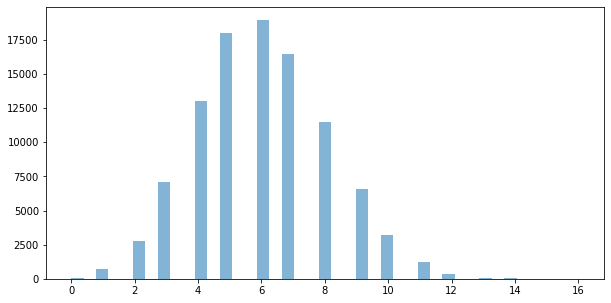

In [8]:
m = 100_000  # Number of simulated values
binom_sample = list(map(lambda x: binom.rvs(n,p), range(m)))
_ = plt.hist(binom_sample, bins=2*n+1, alpha=0.55)

If we conduct $i=1,...,m$ trials,
<p>where $k_i$ is the number of successes on the $i^{th}$ trial,</p>
<p>then the Maximum Likelihood Estimator (MLE) of p for each individual trial is $k_i \over n$</p>
<p>and the MLE for p using the entire set of trials is</p>
<p><center>$\hat{p} = {1 \over m}\left( \sum_{i=1}^{m} {k_i \over n} \right)$,</center></p>

In [9]:
sum = reduce((lambda x, y: x + y), binom_sample)
print(f"Using the data just generated, the MLE for p is {sum/(m*n)}")

Using the data just generated, the MLE for p is 0.3002695


## Bayesian Method

In the calculations, above, we determined the 

Suppose we've run a real-world experiment consisting of a series of $n$ independent trials, where each trial has an unknown probability, $p$, of success, and we've observed a total of $k$ successes.

Then initialize an empty list called <i>posteriors</i>, and do the following:

1. Since we don't know $p$, randomly choose a value, $p_i$, from the Uniform(0,1) distribution
1. Using $p_i$, compute a random value, $k_i$, from a Binomial($n$,$p_i$) distribution
1. If $k_i = k$ save $k_i$ in <i>posteriors</i>, otherwise discard $k_i$.

In [ ]:
m = 1_000_000  # Number of priors to use
hbins = 25  # Number of bins for histograms
n = 20  # Number of trials in our real-world experiment
k = 6  # Number of observed successes in our real-world experiment

The way we'll code this is very simple and succinct for pedigogical purposes.

Let's first compute a list of priors, as described in Step 1, above:

In [ ]:
priors = list(uniform.rvs(size=m))

print(f"First three priors: {priors[:3]}")

_ = plt.hist(priors, bins=hbins, density=True, alpha=0.55)

### Here's the key thing we want to do...

Go through the priors, using each one (p) to simulate Binomial(n,p) observations, keeping only those that match the observed number of successes.

The result, will be the distribution of priors that yielded matches to our actual data (i.e., k = 6).

In [ ]:
%time posteriors = [p for p in priors if binom.rvs(n,p)==6]

print("Number of matches = {}".format(len(posteriors)))
_ = plt.hist(posteriors, bins=hbins, density=True, alpha=0.55)

## Best Fitting Distribution

In [ ]:
fit_results = fd.find_best_fit_distributions(posteriors,
                                             dist_names = fd.common_cont_dist_names,
                                             goodness_of_fit_pvalue = 0.25,
                                             drop_dist_names = []
                                            )

In [ ]:
fit_results

In [ ]:
from scipy.stats import beta

pos = 0
mle = fit_results[pos][1]
dist_name = "beta"

x = np.linspace(beta.ppf(0.001, *mle), beta.ppf(0.999, *mle), 100)

plt.plot(x, beta.pdf(x, *mle), 'r-', lw=3, alpha=0.6, label=dist_name)

_, _, _ = plt.hist(posteriors, hbins, density=True, alpha=0.55)

In [ ]:
print('{} density function (red) for parameters:\n{}'
      .format(dist_name, mle))

### The result matches the theory very well...

The <b>Uniform(0,1)</b> prior, used above, is equivalent to a <b>Beta(1,1)</b> prior.  And, since the beta prior is conjugate with binomial likelihoods, the posterior should be a <b>Beta( 6 + 1, 20 - 6 + 1 ) = Beta(7,15)</b> which is close to what we obtained above.

Here's the math:

First of all, the Uniform distribution is equivalent to a Beta distribution:
<p><center>$U(0,1) \equiv Beta(1,1)$</center></p>
<p>Then, assuming the <i>prior</i> and the <i>likelihood</i> are as follows:</p>
<p><center><u>Prior</u>:  $\pi(\theta) \sim Beta(\alpha, \beta) \equiv \frac{\Gamma(\alpha)\Gamma(\beta)}{\Gamma(\alpha + \beta)} \theta^{\alpha - 1} (1-\theta)^{\beta - 1}$</center></p>
<p><center><u>Likelihood</u>:  $Y \sim Binomial(n,k,\theta) \equiv \binom{n}{k} \theta^k(1-\theta)^{n-k}$</center></p>
<p>So, multiplying the two, followed by some algebraic manipulation, we arrive at:</p>
<p><center><u>Posterior</u>:  $\pi(\theta \mid Y=k) \sim Beta(k+\alpha, n-k+\beta)$</center></p>

## Bibliography

1. <u>Introduction to Mathematical Statistics</u> ...
1. A discussion about the ambiguity of commonly used probability notations: [What’s Wrong with Probability Notation?](https://lingpipe-blog.com/2009/10/13/whats-wrong-with-probability-notation/)